In [ ]:
!pip install pandarallel

  Created wheel for pandarallel: filename=pandarallel-1.5.2-py3-none-any.whl size=18398 sha256=9f69263dbaf2c2ce5c7ae3541c8c59bc2c314d4884a45f4d0faaf7418761f8d4
  Stored in directory: /root/.cache/pip/wheels/b5/6d/51/9ece2eaf007ea3f7fb0ce053c5773b2eb0d308887da3af12c1
Successfully built pandarallel


In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV,
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, make_scorer, roc_curve
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD

from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Doc2Vec

from sklearn.pipeline import Pipeline

import unicodedata
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import SnowballStemmer, PorterStemmer
import string
import nltk
from nltk.tokenize import sent_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
import pandas as pd
import re
from pandarallel import pandarallel
from pandarallel.utils import progress_bars
from tqdm import tqdm


tqdm.pandas()
pandarallel.initialize(progress_bar=True)
progress_bars.is_notebook_lab = lambda : True
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

KeyboardInterrupt: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Data

In [ ]:
df = pd.read_csv("drive/MyDrive/training/HW/data/LargeMovieReviewDataset.csv")
df

In [ ]:
df.info()

In [ ]:
SIZE = df.shape[0]
SIZE

In [ ]:
df.sentiment.value_counts()

In [ ]:
chars_count = df.review.agg(len)
chars_count.max(), chars_count.min(), chars_count.mean(), chars_count.median()

In [ ]:
chars_count.hist(bins=100);

In [ ]:
df

* We can see, that the dataset is balanced. It contains both large (max: 13704 chars) and small (min: 32 chars) sentences. 

# Data preparation

Further we will apply some basic text cleaning and transformation techniques, required for effective vectorization (removing html markup, numbers, punctuation and stopwords; dividing texts into tokens, assigning tags to tokens and text normalization).

## Text cleaning and tagging

Here is the first stage of data preprocessing. We will save the resulted data (these preparations are very long).

In [ ]:
def text_preprocessing(text):
  """
  Remove html markup and numbers, dividing into sentences and wordtokens, and after that assigning tags to tokens.
  """
  return [
          pos_tag(wordpunct_tokenize(sent)) 
          for sent in sent_tokenize(remove_numbers_and_html(text))
  ]


def remove_numbers_and_html(raw_text):
  cleanr = re.compile('\d+|<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
  return re.sub(cleanr, '', raw_text)

* Here we save dataframe to json file.
* We can parralelize this process. 

In [ ]:
%%time
import os

mapper = {
    'negative': 0,
    'positive': 1
}

if os.path.isfile('drive/MyDrive/training/HW/data/tagged.json'):
  df_tagged = pd.read_json('drive/MyDrive/training/HW/data/tagged.json')[['review', 'sent']]
else:
  df_tagged = pd.DataFrame()
  df_tagged['review'], df_tagged['sent'] = df['review'].parallel_apply(text_preprocessing), df.sentiment.map(mapper)
  df_tagged['review', 'sent'].to_json('drive/MyDrive/training/HW/data/tagged.json')

display(df_tagged)

## Normalizaton

* Here is the transformer, which can be used in pipeline (but I abandoned that idea, because it is too long; I created new columns in our data: lemmatized and stemmed data).

In [ ]:
class TextNormalizer(BaseEstimator, TransformerMixin):

  def __init__(self, norm='stem',language = 'english'):
    self.norm = norm
    self.stopwords = set(nltk.corpus.stopwords.words(language))
    
    if self.norm == 'lemm':
      self.lemmatizer = WordNetLemmatizer()
    elif self.norm == 'stem':
      self.stemmer = SnowballStemmer(language)

  def is_punct(self, token):
    return all(
      unicodedata.category(char).startswith('P') for char in token
    )

  def is_stopword(self, token):
    return token.lower() in self.stopwords

  def normalize(self, text):
    if self.norm == 'lemm':
      return [
        self.lemmatize(token, tag).lower()
        for sentence in text
        for (token, tag) in sentence
        if not self.is_punct(token) and not self.is_stopword(token)
      ]
    elif self.norm == 'stem':
        return [
        self.stemmer.stem(token).lower()
        for sentence in text
        for (token, tag) in sentence
        if not self.is_punct(token) and not self.is_stopword(token)
      ]

  def lemmatize(self, token, pos_tag):
      tag = {
          'N': wn.NOUN,
          'V': wn.VERB,
          'R': wn.ADV,
          'J': wn.ADJ
      }.get(pos_tag[0], wn.NOUN)
      return self.lemmatizer.lemmatize(token, tag)

  def fit(self, X, y=None):
      return self

  def transform(self, documents):
      for document in documents['review']:
        yield self.normalize(document)

In [ ]:
%%time
stem_normalizer = TextNormalizer(norm='stem').normalize
lemm_normalizer = TextNormalizer(norm='lemm').normalize

if os.path.isfile('drive/MyDrive/training/HW/data/normalized.json'):
  df_tagged = pd.read_json('drive/MyDrive/training/HW/data/normalized.json', )
else:
  df_tagged['stem'] = df_tagged.review.progress_apply(stem_normalizer)
  df_tagged['lemm'] = df_tagged.review.progress_apply(lemm_normalizer)
  df_tagged.to_json('drive/MyDrive/training/HW/data/normalized.json')

display(df_tagged)

* We can see the difference between stemming and lemmatization. Stemming more roughly cut words, than lemmatization. 

* Let's check some sample before and after normalization.

In [ ]:
df.iloc[0].review

In [ ]:
tn = TextNormalizer(norm='stem')
" ".join(tn.normalize(df_tagged.iloc[0].review))

In [ ]:
tn = TextNormalizer(norm='lemm')
" ".join(tn.normalize(df_tagged.iloc[0].review))

It seems, that everything is ok. Lemmatization gives more readable results.

# WordCloud

Now we will use wordcloud to analyze words in our dataset.

In [ ]:
from wordcloud import WordCloud

In [ ]:
import matplotlib.pyplot as plt
def identity(words):
    return words


def build_wordcloud(texts):
  
  vectorizer_texts = TfidfVectorizer(tokenizer=identity, preprocessor=None, lowercase=False, ngram_range=(1, 1))
  vecs_texts = vectorizer_texts.fit_transform(texts)

  X = vecs_texts
  svd_model = TruncatedSVD(n_components=5, algorithm='randomized', n_iter=100, random_state=42)
  svd_model.fit(X)

  terms = vectorizer_texts.get_feature_names()
  for i, comp in enumerate(svd_model.components_):
      terms_comp = zip(terms, comp)
      sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:15]
      print("Тема "+ str(i + 1) +": ")
      
      #for t in sorted_terms:
          #print(t[0], end = ' ')
      
      text = ' '.join([str(t[0]) for t in sorted_terms])

      # Create and generate a word cloud image:
      wordcloud = WordCloud(background_color="white").generate(text)
      
      # Display the generated image:
      plt.imshow(wordcloud, interpolation='bilinear')
      plt.axis("off")
      plt.show()
      print()

We can remove words, which can often be seen in wordclouds and which may be unnecessary. We will do it for text with different normalizations. 

In [ ]:
build_wordcloud(df_tagged['lemm'])

In [ ]:
def remove_words(tokenized_text, wordset=set()):
  return [i for i in tokenized_text if i not in wordset]

In [ ]:
df_tagged['lemm'] = df_tagged['lemm'].parallel_apply(remove_words,
                                     wordset=set([ 'film', 'movie', 'really']))

In [ ]:
build_wordcloud(df_tagged['stem'])

In [ ]:
df_tagged['stem'] = df_tagged['stem'].parallel_apply(remove_words,
                                     wordset=set([ 'film', 'movi', 'realli']))

# Word Importance

Now we will try to analyze feature importance (word importance). If we cannot see any pattern, probably vectorization worked badly. In other case we can see, what words are most important for training a model. We will use LinearSVC and LogisticRegression with l1 regularization.

In [ ]:
def plot_importance(est, X, y, n_best=10):

  tfidf = TfidfVectorizer(tokenizer=identity, preprocessor=None, lowercase=False)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                      shuffle=True, random_state=42)
  X_train = tfidf.fit_transform(X_train)
  X_test = tfidf.transform(X_test)

  est.fit(X_train, y_train)

  fnames = tfidf.get_feature_names()
  name_coef = zip(fnames, est.coef_[0])
  sorted_name_coef = sorted(name_coef, key=lambda x: x[1], reverse=True)

  positive_best = sorted_name_coef[:n_best]
  negative_best = sorted_name_coef[-n_best:]
  all_best = positive_best + negative_best

  required_words = [i[0] for i in all_best]
  required_coefs = [i[1] for i in all_best]
  
  sns.set_theme(style="whitegrid")
  plt.figure(figsize=(16, 9))
  ax = sns.barplot(x=required_coefs, y=required_words, orient='h');
  ax.set(xlabel='coefficients', ylabel='words', title='Feature Importance')

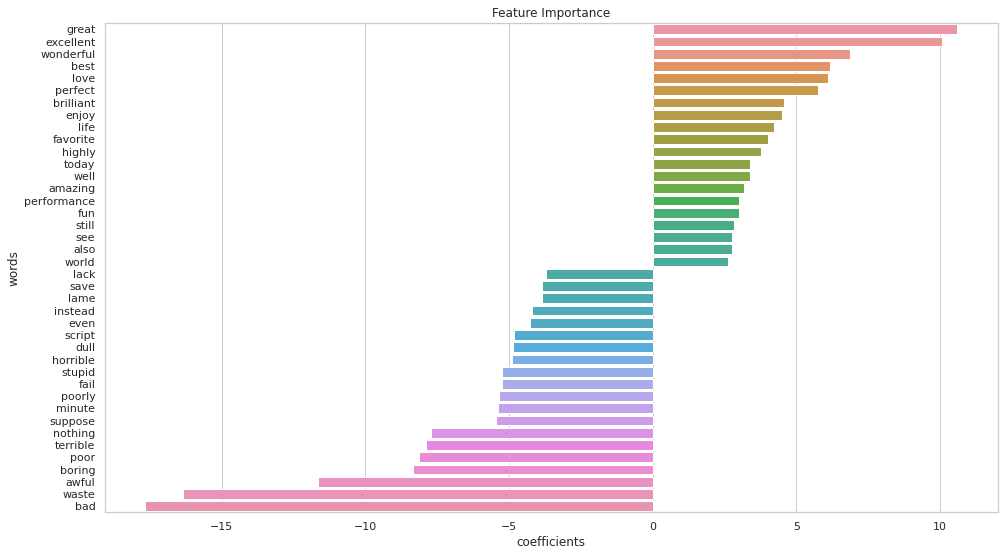

In [ ]:
est = LogisticRegression(solver='liblinear', penalty='l1', C=0.1)
plot_importance(est, df_tagged['lemm'], df_tagged['sent'], 20)

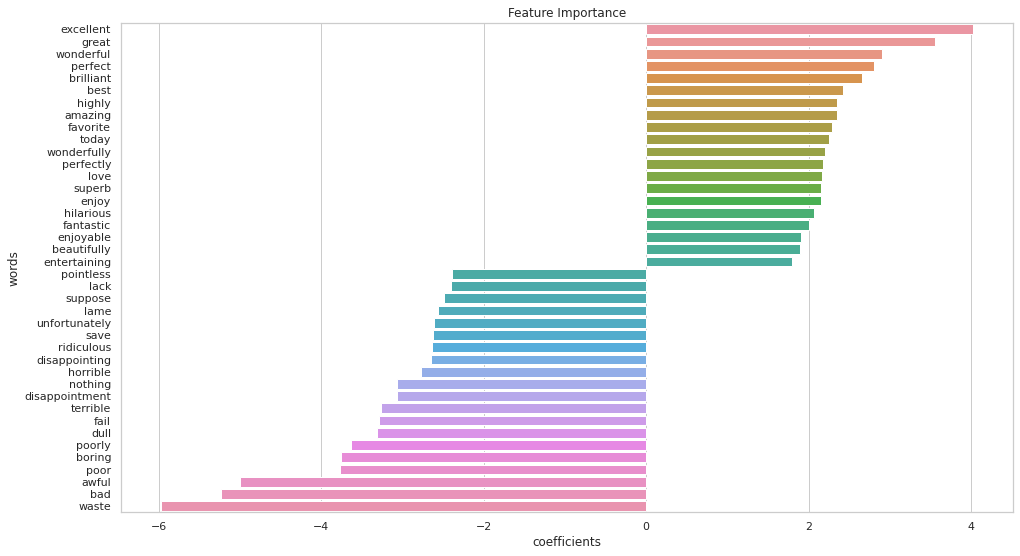

In [ ]:
est = LinearSVC(penalty="l1", dual=False, random_state=42, max_iter=10000, C=0.1)
plot_importance(est, df_tagged['lemm'], df_tagged['sent'], 20)

* As we can see, our 2 models found some patterns in texts: 'positive' words have the highest coefficients (excellent, great, wonderful), 'negative' have the lowest ones (waste, bad, awful, poor). So, vectorization worked well and we can start building classification models.

# Baseline model

We will start with baseline model. We will define function for pipeline creation.

In [ ]:
def identity(words):
    return words

def create_pipeline(estimator):

    steps = [
        ('vectorize', TfidfVectorizer(
            tokenizer=identity, preprocessor=None, lowercase=False
        ))
    ]


    # Add the estimator
    steps.append(('classifier', estimator))
    return Pipeline(steps)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_tagged['stem'], df_tagged['sent'], test_size=0.25, shuffle=True, random_state=42)

pipe = create_pipeline(LogisticRegression())

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_pred_train = pipe.predict(X_train)

print(classification_report(y_test, y_pred))
print("f1 on train:", f1_score(y_train, y_pred_train, average='macro'))
print("f1 on test: ", f1_score(y_test, y_pred, average='macro'))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      6157
           1       0.88      0.91      0.89      6343

    accuracy                           0.89     12500
   macro avg       0.89      0.89      0.89     12500
weighted avg       0.89      0.89      0.89     12500

f1 on train: 0.9268257042262936
f1 on test:  0.8917589740585075


# Models evaluation

I have chosen 3 classification algorythms: Stochastic Gradient Descent, (Linear)Support Vector Machine and Multinomial Naive Bayes.

## Stemming and Lemmatization comparing

In [ ]:
stem_X_train, stem_X_test, y_train, y_test = train_test_split(df_tagged['stem'], df_tagged['sent'], test_size=0.25, shuffle=True, random_state=42)
lemm_X_train, lemm_X_test = train_test_split(df_tagged['lemm'], test_size=0.25, shuffle=True, random_state=42)

In [ ]:
import timeit

def flatten(t):
    return [item for sublist in t for item in sublist]

def evaluate_models(estimators, names, X_train, X_test, y_train, y_test, conf={}):

  names = [[name + '_stem', name + '_lemm'] for name in names]
  names = flatten(names)

  estimators = [[(est, 'stem'), (est, 'lemm')] for est in estimators]
  estimators = flatten(estimators)

  results_df = pd.DataFrame(index=names, columns=['accuracy', 'f1', 'roc_auc', 'time'])
  у_pred_list = []
  у_pred_train_list = []
  estimators_with_info = list(zip(names, estimators))
  for (name, (est, est_norm)) in tqdm(estimators_with_info):
    
    pipe = create_pipeline(est(**conf.get(est, {})))
    if est_norm == 'stem':
      X_train = stem_X_train
      X_test = stem_X_test
    elif est_norm == 'lemm':
      X_train = lemm_X_train
      X_test = lemm_X_test

    start = timeit.default_timer()
    pipe.fit(X_train, y_train)
    stop = timeit.default_timer()
    
    y_pred = pipe.predict(X_test)
    try:
      y_proba = pipe.decision_function(X_test)
    except AttributeError:
      y_proba = pipe.predict_proba(X_test)[:, 1:]
    y_pred_train = pipe.predict(X_train)
    


    results_df.loc[name]['accuracy'] = accuracy_score(y_test, y_pred)
    results_df.loc[name]['f1'] = f1_score(y_test, y_pred)
    results_df.loc[name]['roc_auc'] = roc_auc_score(y_test, y_proba)
    results_df.loc[name]['time'] = stop - start
    #metrics.plot_roc_curve(pipe, stem_X_test, y_test)  
    #plt.show() 

    у_pred_list.append(y_pred)
    у_pred_train_list.append(y_pred_train)

  return results_df, у_pred_list, у_pred_train_list

In [ ]:
res, у_pred_list, у_pred_train_list = evaluate_models([SGDClassifier, MultinomialNB , LinearSVC], 
                ['SGD', 'MultNB', 'LSVC'],  
                X_train, X_test, y_train, y_test)

100%|██████████| 6/6 [00:46<00:00,  7.68s/it]


In [ ]:
res

,accuracy,f1,roc_auc,time
SGD_stem,0.89192,0.895247,0.959156,2.95349
SGD_lemm,0.89224,0.895944,0.9591,3.60365
MultNB_stem,0.8592,0.858952,0.935493,2.6287
MultNB_lemm,0.86184,0.86114,0.937442,2.91705
LSVC_stem,0.89256,0.895283,0.959232,3.24027
LSVC_lemm,0.8932,0.895466,0.959846,3.58876


* So, we can see that models trained faster with stemmed text. Also, there is almost no difference in metrics. The reason is that englsih words have very simple structure (for example, in comparison to russian). So there is almost no difference, to roughly cut words or do it more smart.

## Parameters searching

Here we will try to find best parameters for our 3 models. We will use 3 mtrics: accuracy, f1 and roc_auc_score (we have balanced dataset, so we can use accuracy).  Also, we will compare work time.

In [ ]:
def make_grid_search(est, cv, params):
  gs = GridSearchCV(est, params, 
                    n_jobs=-1, 
                    scoring='roc_auc',
                    cv=cv,
                    verbose=10)
  return gs


def count_params_number(params_dict):
    params_number = 1
    for item in params_dict.items():
      params_number *= len(item[1])
    return params_number


def predict_proba(est, X):
    try:
      y_proba = est.decision_function(X)
    except AttributeError:
      y_proba = est.predict_proba(X)[:, 1:]
    return y_proba


def evaluate_models_grid(estimators, names, X_train, X_test, y_train, y_test, params, cv=3):

  names = [name + '_stem' for name in names]

  estimators = [(est, 'stem') for est in estimators]

  cv = KFold(n_splits=cv, shuffle=True, random_state=42)

  results_df = pd.DataFrame(index=names, columns=['accuracy', 'accuracy_tr', 'f1', 'f1_tr', 'roc_auc', 
                                                  'roc_auc_tr', 'time_total', 'time_per_fold'])
  
  у_pred_list = []
  у_pred_train_list = []
  y_proba_list = []
  best_params = []

  estimators_with_info = list(zip(names, estimators))
  for (name, (est, est_norm)) in tqdm(estimators_with_info):
    print()

    pipe = create_pipeline(est())
    gs = make_grid_search(pipe, cv, params.get(est, {}))

    start = timeit.default_timer()
    gs.fit(X_train, y_train)
    stop = timeit.default_timer()

    y_pred = gs.predict(X_test)
    y_pred_train = gs.predict(X_train)
    y_proba = predict_proba(gs, X_test)
    y_proba_train = predict_proba(gs, X_train)
    
    params_number = count_params_number(params.get(est, {}))
    results_df.loc[name]['accuracy'] = accuracy_score(y_test, y_pred)
    results_df.loc[name]['accuracy_tr'] = accuracy_score(y_train, y_pred_train)
    results_df.loc[name]['f1'] = f1_score(y_test, y_pred)
    results_df.loc[name]['f1_tr'] = f1_score(y_train, y_pred_train)
    results_df.loc[name]['roc_auc'] = roc_auc_score(y_test, y_proba)
    results_df.loc[name]['roc_auc_tr'] = roc_auc_score(y_train, y_proba_train)
    results_df.loc[name]['time_total'] = (stop - start)
    results_df.loc[name]['time_per_fold'] = (stop - start)/(params_number * gs.cv.n_splits)

    
    у_pred_list.append(y_pred)
    у_pred_train_list.append(y_pred_train)
    y_proba_list.append(y_proba)
    best_params.append(gs.best_params_)
  return results_df, у_pred_list, у_pred_train_list, y_proba_list, best_params

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_tagged['stem'], df_tagged['sent'], test_size=0.25, shuffle=True, random_state=42)

params = {
    MultinomialNB : {'classifier__alpha':  np.logspace(-8, 2, 30)},
    LinearSVC : {'classifier__penalty' : ['l1', 'l2'], 'classifier__C' : np.logspace(-8, 2, 30)},
    SGDClassifier : {
        'classifier__penalty' : ['elasticnet'],
        'classifier__loss' :  ['hinge', 'log', 'modified_huber'],
        'classifier__alpha' :  np.logspace(-7, 2, 5),
        'classifier__l1_ratio' : np.logspace(-7, 0, 5)
    }
}

res, у_pred_list, у_pred_train_list, y_proba_list, best_params = evaluate_models_grid([SGDClassifier, MultinomialNB,  LinearSVC], 
                ['SGD', 'MultNB', 'LSVC'],  
                X_train, X_test, y_train, y_test, 
                params,
                cv=3)

  0%|          | 0/3 [00:00<?, ?it/s]


Fitting 3 folds for each of 75 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  9


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  5.6min finished
 67%|██████▋   | 2/3 [21:02<09:40, 580.74s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  9.0min
[Paralle

\* Here is mistake: used stemmed data, not lemmatized.

In [ ]:
res

,accuracy,accuracy_tr,f1,f1_tr,roc_auc,roc_auc_tr,time_total,time_per_fold
SGD_lemm,0.8932,0.935867,0.896391,0.936219,0.960393,0.982463,911.125,4.04944
MultNB_lemm,0.85616,0.87984,0.852984,0.875318,0.935491,0.952531,337.617,3.7513
LSVC_lemm,0.89552,0.941013,0.898255,0.941111,0.961306,0.985008,646.625,3.59236


In [ ]:
best_params

[{'classifier__alpha': 1.778279410038923e-05,
  'classifier__l1_ratio': 0.00031622776601683794,
  'classifier__loss': 'log',
  'classifier__penalty': 'elasticnet'},
 {'classifier__alpha': 4.175318936560409},
 {'classifier__C': 0.1743328822199991, 'classifier__penalty': 'l2'}]

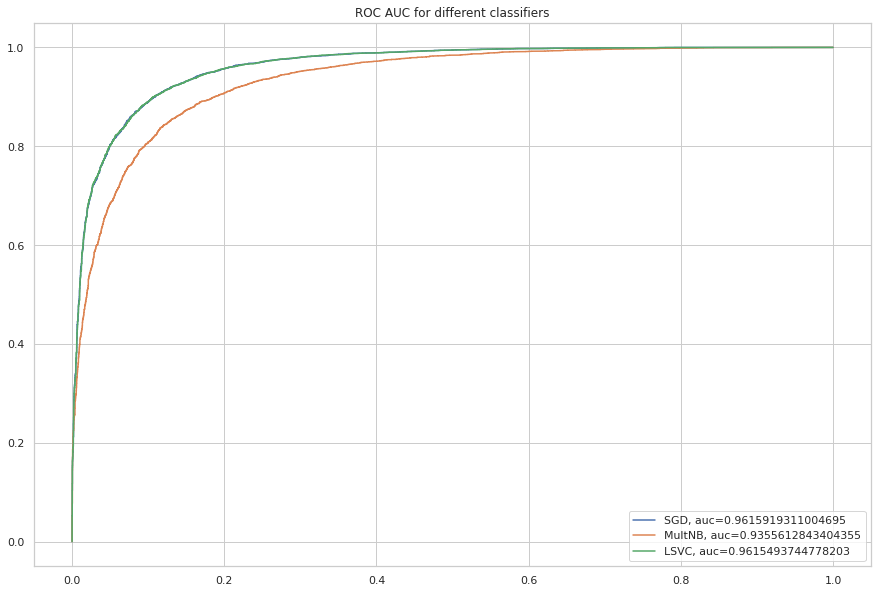

In [ ]:
plt.figure(figsize=(15, 10))
plt.grid(True)
plt.title('ROC AUC for different classifiers')

for y_pred_proba, classifier in zip(y_proba_list, ['SGD', 'MultNB', 'LSVC']):
  fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
  auc = roc_auc_score(y_test, y_pred_proba)
  plt.plot(fpr, tpr, label=f"{classifier}, auc={auc}")
  plt.legend(loc=4)
plt.show()

* So, we got our first results of tuning. We can see, that SGD and LSVC showed close results. Let's try to narrow the search area and try to find better parameters.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_tagged['stem'], df_tagged['sent'], test_size=0.25, shuffle=True, random_state=42)

params = {
    MultinomialNB : {'classifier__alpha':  np.linspace(3, 4, 30)},
    LinearSVC : {'classifier__penalty' : ['l1', 'l2'], 'classifier__C' : np.linspace(0.15, 0.3, 20)},
    SGDClassifier : {
        'classifier__penalty' : ['elasticnet'],
        'classifier__loss' :  ['hinge', 'log', 'modified_huber'],
        'classifier__alpha' :  np.logspace(-6, -4, 6),
        'classifier__l1_ratio' : np.logspace(-6, -4, 6)
    }
}

res, у_pred_list, у_pred_train_list, y_proba_list, best_params = evaluate_models_grid([SGDClassifier, MultinomialNB,  LinearSVC], 
                ['SGD', 'MultNB', 'LSVC'],  
                X_train, X_test, y_train, y_test, 
                params,
                cv=3)

  0%|          | 0/3 [00:00<?, ?it/s]


Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  9


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  5.5min finished
 67%|██████▋   | 2/3 [28:06<12:34, 754.67s/it] [Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  6.8min finished
100%|██████████| 3/3 [35:03<00:00, 701.03s/it]


In [ ]:
res

,accuracy,accuracy_tr,f1,f1_tr,roc_auc,roc_auc_tr,time_total,time_per_fold
SGD_lemm,0.89352,0.938587,0.895501,0.938295,0.960605,0.983496,1336.94,4.12635
MultNB_lemm,0.856,0.880453,0.852965,0.876054,0.935506,0.952802,335.328,3.72587
LSVC_lemm,0.8956,0.948267,0.898357,0.948286,0.961569,0.987726,410.152,3.41793


In [ ]:
best_params

[{'classifier__alpha': 1.584893192461114e-05,
  'classifier__l1_ratio': 1.584893192461114e-05,
  'classifier__loss': 'log',
  'classifier__penalty': 'elasticnet'},
 {'classifier__alpha': 4.0},
 {'classifier__C': 0.2368421052631579, 'classifier__penalty': 'l2'}]

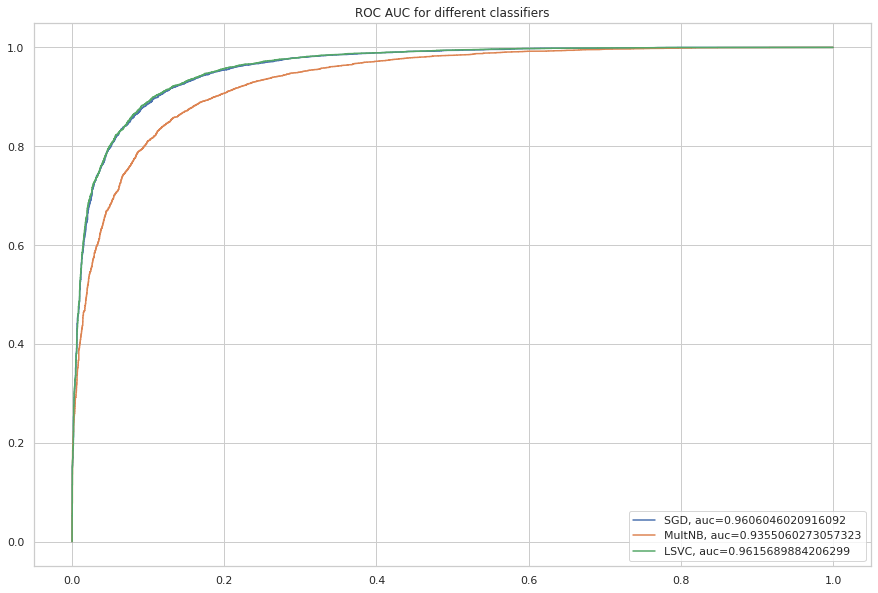

In [ ]:
plt.figure(figsize=(15, 10))
plt.grid(True)
plt.title('ROC AUC for different classifiers')

for y_pred_proba, classifier in zip(y_proba_list, ['SGD', 'MultNB', 'LSVC']):
  fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
  auc = roc_auc_score(y_test, y_pred_proba)
  plt.plot(fpr, tpr, label=f"{classifier}, auc={auc}")
  plt.legend(loc=4)
plt.show()

* We cannot see any significant changes, results only slightly changed for some models.

In this work:

* We cleaned and normalized text data;
* Used TF-IDF to vectorize texts;
* Used WordCloud to analyze text and find important words;
* Used some Linear models to find important words;
* Compared different normalization strategies (stemming faster, but text after lemmatization is more readable for human);
* Used 3 classification algorithms and compared them (the fastest - Linear SVC (4.13 per fold), the slowest - SGD(3.42 per fold));
* The best results are shown by Linear SVC and SGD (roc_auc: 0.961 and 0.960 accordingly).
* Entirely, text classification require more RAM for working with large amount of features. Also, text classification model require more time for training.